In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path_prefix = "/content/drive/My Drive/zero_shot/"

In [3]:
import numpy as np

import os
from collections import Counter

from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.neighbors import KDTree
import tensorflow as tf
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16


import matplotlib.pyplot as plt


np.random.seed(1234)
WORD2VECPATH    = path_prefix + "data/class_vectors.npy"
# DATAPATH        = "../data/zeroshot_data.pkl"
MODELPATH       = path_prefix + "DatasetA_train_20180813/model/"
MODELNAME       = "model_2"

In [4]:
def save_keras_model(model, model_path):
    """save Keras model and its weights"""
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    model_json = model.to_json()
    with open(model_path + MODELNAME +  ".json", "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights(model_path + MODELNAME + ".h5")
    print("-> zsl model is saved.")
    return

def load_keras_model(model_path):
    with open(model_path + MODELNAME + ".json", 'r') as json_file:
        loaded_model_json = json_file.read()

    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_path + MODELNAME + ".h5")
    return loaded_model

def build_model():
    model  = Sequential()
    base_model = VGG16(include_top=False, input_shape=(224,224,3))
    for layer in base_model.layers:
        layer.trainable = False
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(NUM_ATTR, activation='relu'))
    model.add(Dense(NUM_CLASS, activation='softmax', trainable=False))#, kernel_initializer=custom_kernel_init))
    return model


def train_model(model, train_ds, val_ds):
    adam = Adam(lr=5e-5)
    model.compile(loss      = 'categorical_crossentropy',
                  optimizer = adam,
                  metrics   = ['categorical_accuracy', 'top_k_categorical_accuracy'])

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCH
    )

    print("model training is completed.")
    return history

In [5]:
global train_classes
with open(path_prefix + 'DatasetA_train_20180813/label_list.txt', 'r') as infile:
    name_classes = [str.strip(line).split('\t') for line in infile]
  #Lets take 30 as Zsl classes
global zsl_classes
indexes = np.arange(0, len(name_classes))
zsl_indexes = np.random.choice(indexes, size=30, replace=False)
zsl_classes = np.array(name_classes)[zsl_indexes]
train_classes= []
for i,obj in enumerate(name_classes):
    if not obj in zsl_classes:
        train_classes.append(obj)

In [8]:
# ---------------------------------------------------------------------------------------------------------------- #
# ---------------------------------------------------------------------------------------------------------------- #
# SET HYPERPARAMETERS

global NUM_CLASS, NUM_ATTR, EPOCH, BATCH_SIZE
NUM_CLASS = 200
NUM_ATTR = 300
BATCH_SIZE = 128
EPOCH = 15

# ---------------------------------------------------------------------------------------------------------------- #
# ---------------------------------------------------------------------------------------------------------------- #
# TRAINING PHASE

data_dir = path_prefix + 'data/ordered_data/training'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", image_size=(224,224), seed=1234, batch_size=BATCH_SIZE, label_mode='categorical')

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, image_size=(224,224), subset="validation", seed=1234, batch_size=BATCH_SIZE, label_mode='categorical')

model = build_model()
model.summary()
train_model(model, train_ds, val_ds)
# ---------------------------------------------------------------------------------------------------------------- #
# ---------------------------------------------------------------------------------------------------------------- #
# CREATE AND SAVE ZSL MODEL

inp         = model.input
out         = model.layers[-2].output
zsl_model   = Model(inp, out)
print(zsl_model.summary())
save_keras_model(zsl_model, model_path=MODELPATH)

Found 32543 files belonging to 200 classes.
Using 26035 files for training.
Found 32543 files belonging to 200 classes.
Using 6508 files for validation.
58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 300)               153900    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               60200     
Total params: 27,774,356
Trainable p

Found 5678 files belonging to 30 classes.
['ZJL103', 'ZJL104', 'ZJL105', 'ZJL107', 'ZJL126', 'ZJL128', 'ZJL138', 'ZJL140', 'ZJL151', 'ZJL168', 'ZJL170', 'ZJL171', 'ZJL174', 'ZJL18', 'ZJL190', 'ZJL194', 'ZJL197', 'ZJL199', 'ZJL221', 'ZJL227', 'ZJL40', 'ZJL46', 'ZJL57', 'ZJL62', 'ZJL65', 'ZJL67', 'ZJL8', 'ZJL80', 'ZJL91', 'ZJL98']
{'ZJL170': 'vestment', 'ZJL18': 'slug', 'ZJL105': 'pan', 'ZJL168': 'turnstile', 'ZJL104': 'car', 'ZJL40': 'grasshopper', 'ZJL126': 'oboe', 'ZJL140': 'reel', 'ZJL128': 'meter', 'ZJL199': 'seashore', 'ZJL103': 'fountain', 'ZJL62': 'altar', 'ZJL197': 'reef', 'ZJL227': 'projector', 'ZJL80': 'broom', 'ZJL151': 'sombrero', 'ZJL171': 'viaduct', 'ZJL107': 'mask', 'ZJL190': 'pomegranate', 'ZJL91': 'stocking', 'ZJL57': 'baboon', 'ZJL8': 'scorpion', 'ZJL138': 'projectile', 'ZJL46': 'butterfly', 'ZJL67': 'barn', 'ZJL65': 'bannister', 'ZJL98': 'desk', 'ZJL174': 'tower', 'ZJL194': 'espresso', 'ZJL221': 'clock'}
Able to predict :)
[['ZJL1', 'goldfish'], ['ZJL10', 'tarantula']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

['ZJL40' 'grasshopper']
['ZJL46' 'butterfly']
['ZJL170' 'vestment']
['ZJL65' 'bannister']
['ZJL140' 'reel']
['ZJL65' 'bannister']
['ZJL126' 'oboe']
['ZJL40' 'grasshopper']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


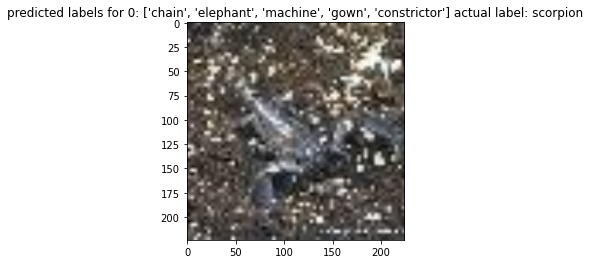

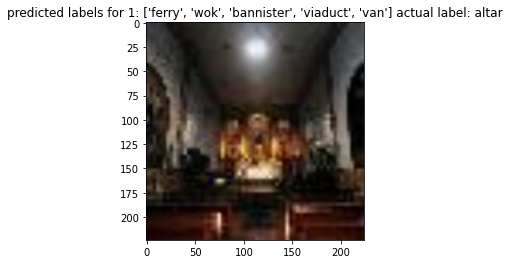

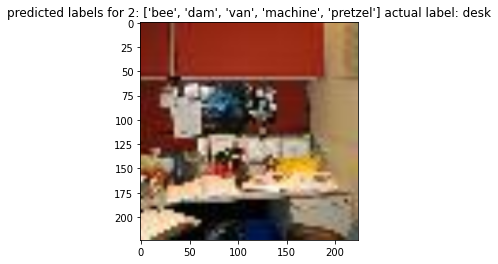

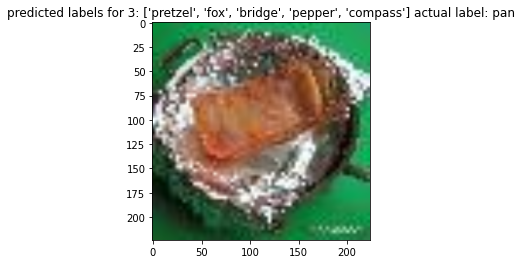

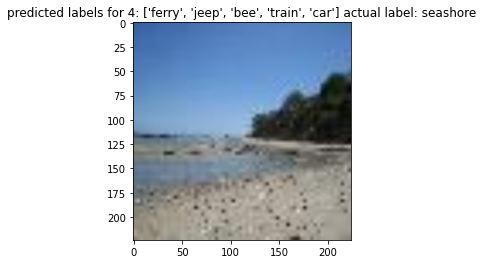

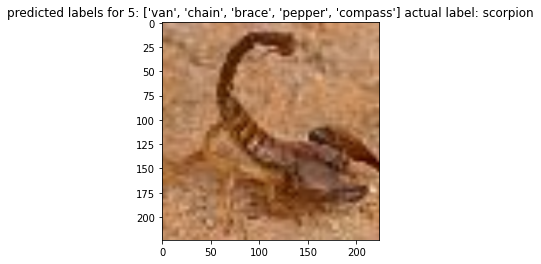

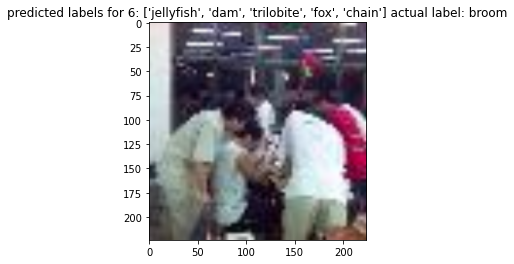

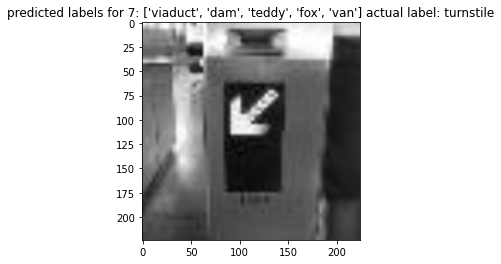

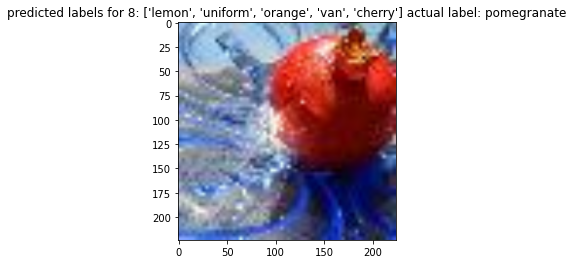

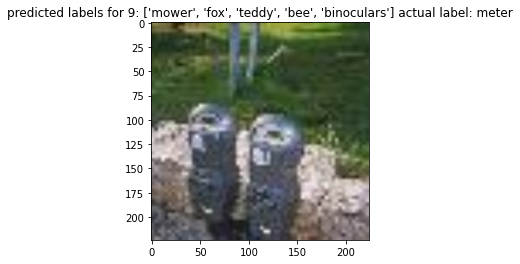

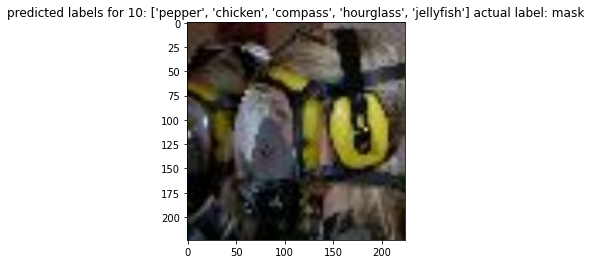

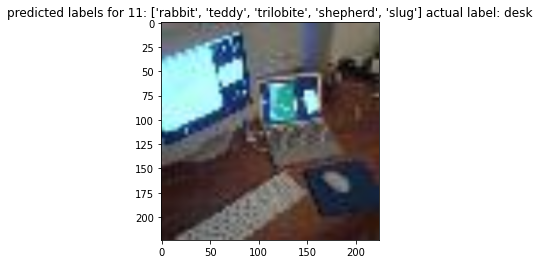

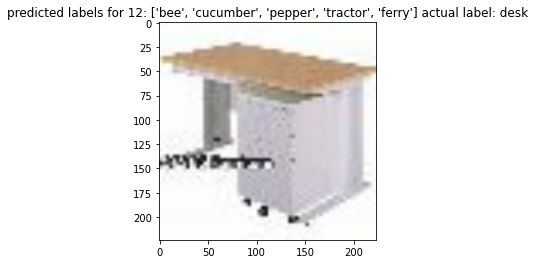

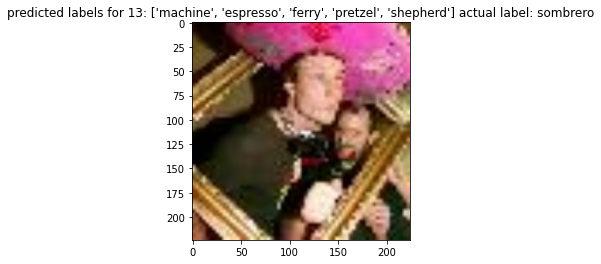

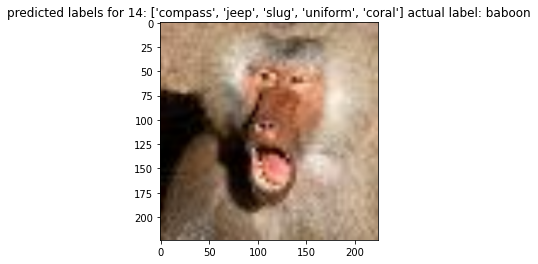

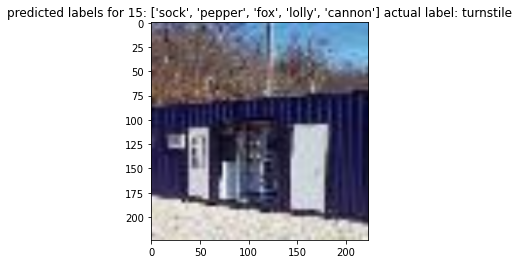

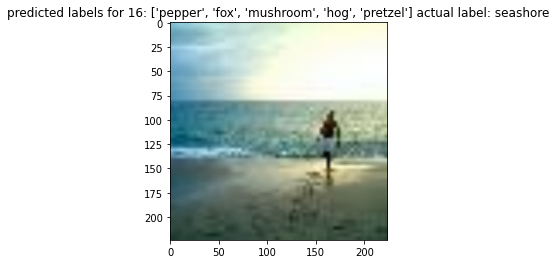

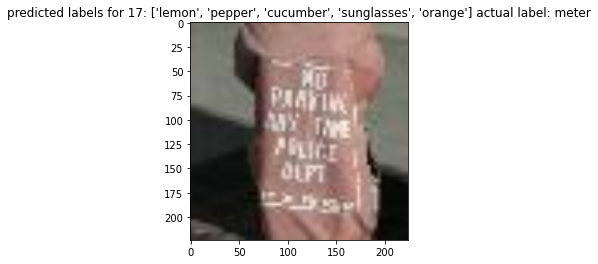

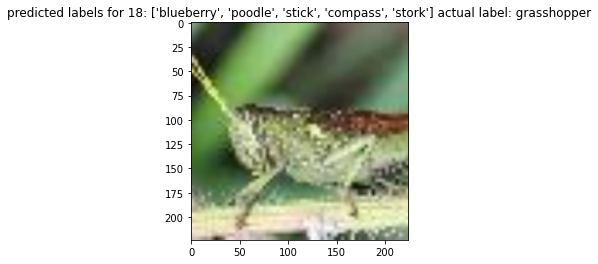

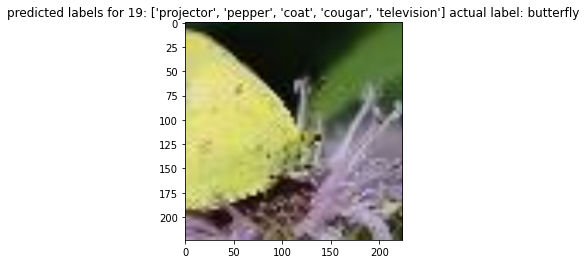

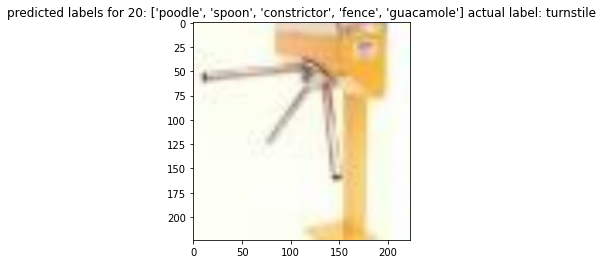

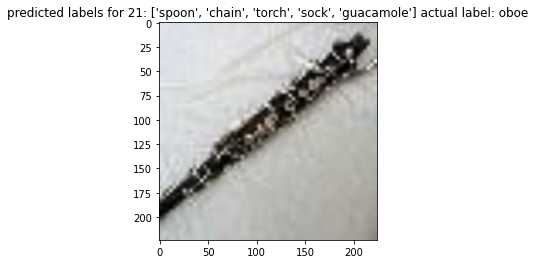

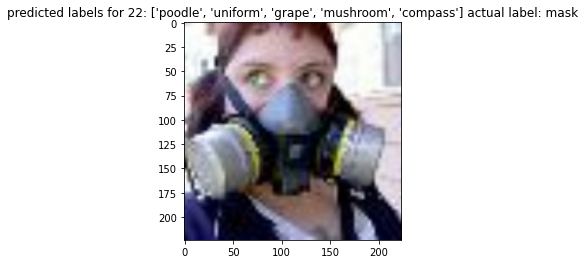

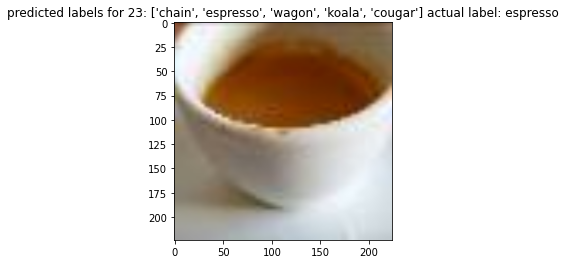

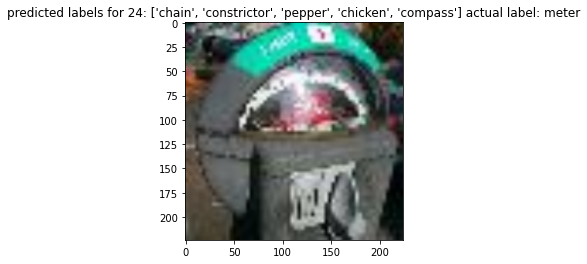

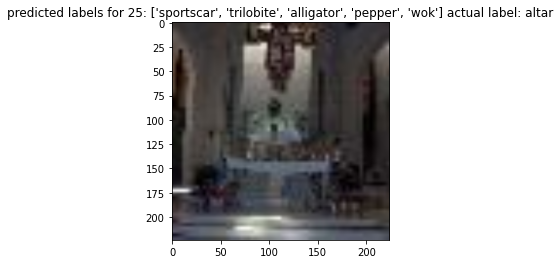

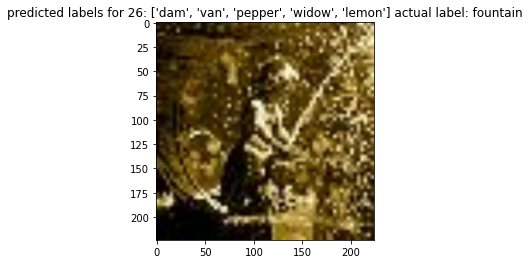

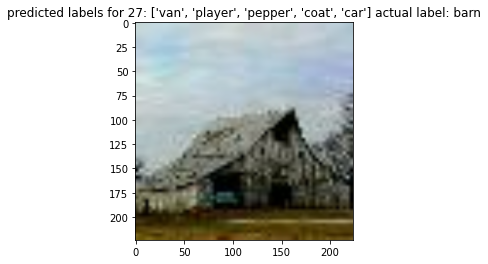

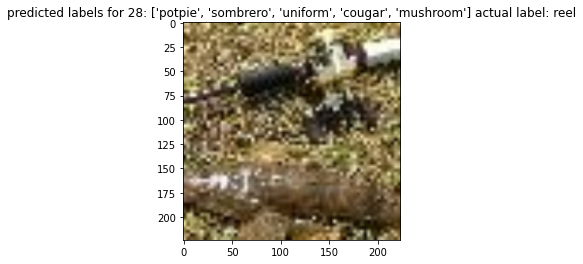

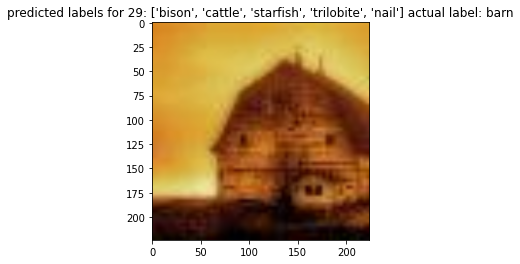

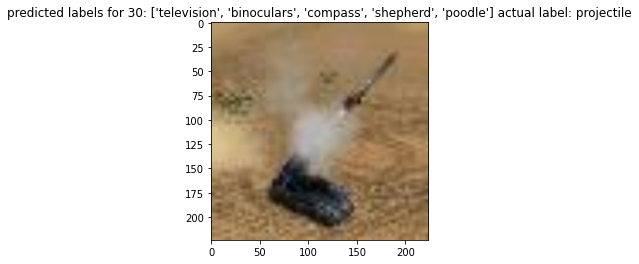

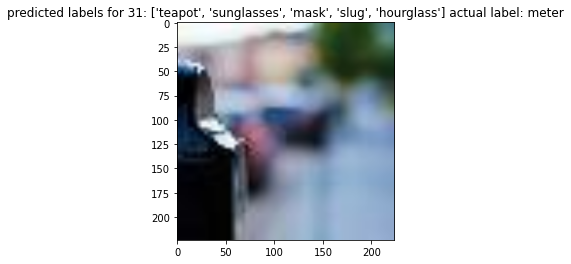

In [9]:
zsl_dir = path_prefix + 'data/ordered_data/zeroshot'

zsl_ds = tf.keras.preprocessing.image_dataset_from_directory(zsl_dir, seed=1234, image_size=(224,224))

print(zsl_ds.class_names)
zsl_labels = zsl_ds.class_names
zsl_class_dict = {}

for label_class in zsl_classes:
    zsl_class_dict[label_class[0]] = label_class[1]

print(zsl_class_dict)

zsl_ds = zsl_ds.take(1)

zsl_model = load_keras_model(model_path=MODELPATH)

with open(path_prefix + 'DatasetA_train_20180813/class_wordembeddings.txt', 'r') as infile:
    class_wordembeddings = [str.strip(line).split(' ') for line in infile]

with open(path_prefix + 'DatasetA_train_20180813/label_list.txt', 'r') as infile:
    name_classes = [str.strip(line).split('\t') for line in infile]

sorted_embedings = [embed for x in name_classes for embed in class_wordembeddings if embed[0] == x[1]]

vectors = np.array(sorted_embedings)[:,1:]
vectors = np.asarray(vectors, dtype=np.float)

classnames = list(np.array(sorted_embedings)[:,0])



# class_vectors       = sorted(np.load(WORD2VECPATH), key=lambda x: x[0])
# classnames, vectors = zip(*class_vectors)
# classnames          = list(classnames)
# vectors             = np.asarray(vectors, dtype=np.float)

# for images in zsl_ds:
#     print(images[0].numpy().shape)
#     print(images[1])
#     # for i in range(images[0].numpy().shape[0]):
#     for i in range(1):
#         print("displaying image " + str(i))
#         image = images[0].numpy()[i]
#         image = 1. - image / 127.5
#         print(image)
#         plt.imshow(image)

tree        = KDTree(vectors)
pred_zsl    = zsl_model.predict(zsl_ds)


print("Able to predict :)")

top5, top3, top1 = 0, 0, 0

print(name_classes)
print(zsl_classes)

for images in zsl_ds:
    print(images[0].numpy().shape)
    print(images[1])
    for i in range(32):
        prediction = pred_zsl[i]
        image = images[0].numpy()[i]
        pred = np.expand_dims(prediction, axis=0)
        dist_5, index_5 = tree.query(pred, k=5)
        pred_labels = [classnames[index] for index in index_5[0]]
        actual_label = zsl_class_dict[zsl_labels[images[1][i]]]
        print(zsl_classes[images[1][i]])
        # image = 1. - image / 127.5
        plt.figure()
        plt.imshow(image.astype("uint8"))
        plt.title("predicted labels for " + str(i) + ": " + str(pred_labels) + " actual label: " + actual_label)

# for i, pred in enumerate(pred_zsl):
#     pred            = np.expand_dims(pred, axis=0)
#     dist_5, index_5 = tree.query(pred, k=5)
#     pred_labels     = [classnames[index] for index in index_5[0]]
    # print("label for " + str(i) + ":" + str(pred_labels))
    # plt.imshow(zsl_ds[i].numpy().astype("float32"))
    # plt.title(",".join(pred_labels))
    # plt.axis("off")

    # true_label      = y_zsl[i]
    # if true_label in pred_labels:
    #     top5 += 1
    # if true_label in pred_labels[:3]:
    #     top3 += 1
    # if true_label in pred_labels[0]:
    #     top1 += 1

# print()
# print("ZERO SHOT LEARNING SCORE")
# print("-> Top-5 Accuracy: %.2f" % (top5 / float(len(x_zsl))))
# print("-> Top-3 Accuracy: %.2f" % (top3 / float(len(x_zsl))))
# print("-> Top-1 Accuracy: %.2f" % (top1 / float(len(x_zsl))))
